In [1]:
# Importer
import classes.utils as utils
from classes.importer import Importer
from classes.cleaner import Cleaner
from classes.feature_engineer import FeatureEngineer

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker


utils.set_parent_directory_as_working_directory()

# TODO: Move this to a config file
# Importing
DATA_FOLDER = "./data"
KAGGLE_DATASET_NAME = "wordsforthewise/lending-club" 
RAW_DATA_FOLDER = DATA_FOLDER + "/raw"

# Cleaning
RAW_DATA_PATH  = RAW_DATA_FOLDER + "/accepted_2007_to_2018Q4.csv"

# Feature Engineering
CLEAN_DATA_PATH = DATA_FOLDER +'/clean_data.csv'

# Dates
DATES_DATA_PATH = DATA_FOLDER + '/dates_data.csv'

# 1 Loading data

The dataset from [kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club) comes into 2 different datasets, one with the accepted loans and the other one with the rejected requests.

I have created an importer object that downloads the data from kaggle and leaves only the csv's, as when downloading the data you get other files and folders.

In [2]:
# Import the data
importer_name = "importer"
importer = Importer(
    name=importer_name
    , data_folder=DATA_FOLDER
    , kaggle_dataset_name=KAGGLE_DATASET_NAME
    , destination_directory=RAW_DATA_FOLDER
    )

importer.execute()

Executing importer step
Data downloaded to ./data
All CSV files in ./data have been moved to ./data/raw
All files and directories in ./data except for /Users/alejandroprietovelasco/personal/TFM/TFM_MLOps/mlflow_project/data/raw have been deleted
Finished executing importer step


# 2 Data cleaning
We are just going to work only with the dataset of accepted loans (as they are the only ones we know if they haven't been paid). We need to perform some clening tasks before being able to feed a model with this data.

- Select variables available for an investor before deciding to fund the loan. There are some variables in the dataset that we can only know after the loan has been granted and that therefore can cause a [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/) problems. The description of these variables can be found in [this dictionary](https://www.kaggle.com/datasets/jonchan2003/lending-club-data-dictionary?select=Lending+Club+Data+Dictionary+Approved.csv)

- Missing values

Let's see step by step what the execute method do for the cleaner object


In [3]:
cleaner_name = "cleaner"
columns_to_keep =  pd.read_csv('src/available_features.csv')
columns_to_keep = columns_to_keep['features'].tolist()
date_cols=['issue_d']

cleaner = Cleaner(
    name=cleaner_name
    , data_path = RAW_DATA_PATH 
    , date_cols = date_cols
    , columns_to_keep = columns_to_keep
    , destination_directory = DATA_FOLDER
    , null_threshold=30
    , target_variable='loan_status'
    , max_corr=0.75)

cleaner.load_data(RAW_DATA_PATH, date_cols)
# cleaner.execute()

/Users/alejandroprietovelasco/personal/TFM/TFM_MLOps/mlflow_project/src/classes/intermediate_step.py:41: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(data_path, parse_dates=date_cols, index_col=index_col


Data loaded from ./data/raw/accepted_2007_to_2018Q4.csv


Before start preprocessing I am going to save the data regarding the issued dated of the loan, the total length in months, the status and the last payment date as we will need it later.

In [4]:
cleaner._create_dates_data()

Dates data saved to ./data


## 2.1 Variables available
As previously mentioned, here I am just going to use those variables that I understand that would be available at the time of accepting or not a loan.

I am dropping URL, emp_title and title as the first one have many distinct values and the the other require some text processing and cleaning as they are manually populated.

In [5]:
cleaner._keep_columns(columns_to_keep)
cleaner.check_data()

Columns kept ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'desc', 'fico_range_high', 'fico_range_low', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'member_id', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'verification_status', 'verification_status_joint', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'disbursement_method']


,Data Types,Null Percentages,0,1,2
addr_state,object,0.001460,PA,SD,IL
annual_inc,float64,0.001637,55000.0,65000.0,63000.0
annual_inc_joint,float64,94.660506,NaN,NaN,71000.0
application_type,object,0.001460,Individual,Individual,Joint App
desc,object,94.423544,NaN,NaN,NaN
fico_range_high,float64,0.001460,679.0,719.0,699.0
fico_range_low,float64,0.001460,675.0,715.0,695.0
home_ownership,object,0.001460,MORTGAGE,MORTGAGE,MORTGAGE
initial_list_status,object,0.001460,w,w,w
installment,float64,0.001460,123.03,820.28,432.66


## 2.2 Missing values

We are going to drop any column with more than 30% of missing values, and any row with nulls in either loan_status or issue_d as teh first one is the objective variable and the second is the variable we need to divide the dataset into periods

In [6]:
cleaner._drop_columns_nulls(30)

Columns with null percentages higher than 30 dropped.


## 2.3 Highly correlated features

We are goin to drop highly correlated features and keep only one of them

/Users/alejandroprietovelasco/personal/TFM/TFM_MLOps/mlflow_project/src/classes/cleaner.py:145: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = self.data.corr()


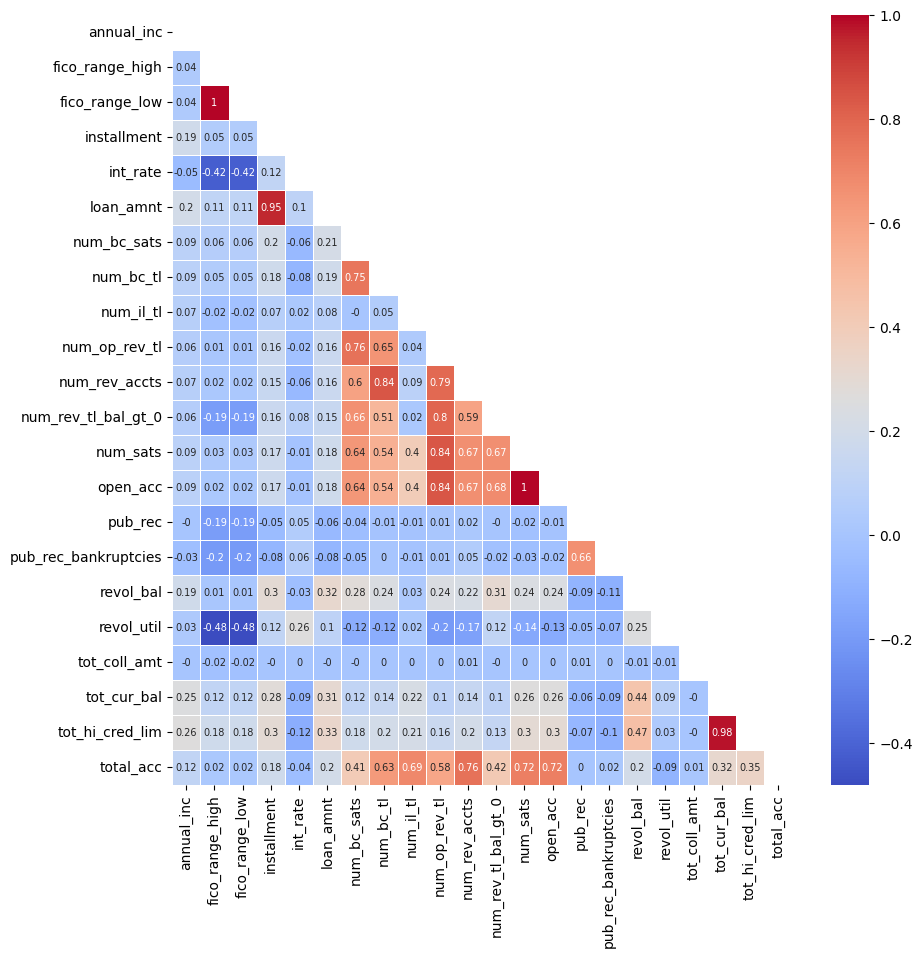

In [7]:
cleaner.corr_heatmap()

We can see some high correlated features, I am going to use a threshold of +/- 0.75 in the pearson correlation index to drop one of the features 

In [8]:
cleaner._drop_high_correlation_vars(0.75)

/Users/alejandroprietovelasco/personal/TFM/TFM_MLOps/mlflow_project/src/classes/cleaner.py:115: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = self.data.corr().abs()


Columns with correlation higher than 0.75 dropped.


## 2.4 Saving data

In [9]:
cleaner.save_data(DATA_FOLDER, 'clean_data.csv')

Data saved to ./data


# 3 Feature engineering

In the feature engineering part we are going to do the following tasks:

- Split date columns into month and year (as issue_d only have this information)
- Fill missing values in categorical variables with the string 'Missing' and in numerical variables with the median
- Binarize target variable
- Convert categorical variables into numerical variables with one hot encoding
- Convert target variable into a binary variable
- Standardize numerical variables
- Save the data

In [10]:
feature_engineer_name = "feature_engineer"

feature_engineer = FeatureEngineer(
    name = feature_engineer_name
    , data_path = CLEAN_DATA_PATH
    , date_cols = ['issue_d']
    , true_labels = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period']
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
)

#feature_engineer.execute()

feature_engineer.load_data(CLEAN_DATA_PATH, feature_engineer.date_cols)

Data loaded from ./data/clean_data.csv


## 3.1 Split date columns into month and year

In order to feed the model with dates information, one way to put them in a format that model can understand is to split them into month and year. We are going to do this for the following columns:

In [11]:
feature_engineer._split_date_columns()

Splitting issue_d into issue_d_month and issue_d_year


## 3.2 Fill missing values

We are going to fill missing values in categorical variables with the string 'Missing' and in numerical variables with the median. Due tu the size of the dataset (2+ million rows) I couldn't use other methods like KNN imputer or MICE as they were taking too long to run.

In [12]:
feature_engineer._fill_missing_values(exclude_cols=[feature_engineer.target_variable])

Missing values filled in columns Index(['Unnamed: 0', 'addr_state', 'annual_inc', 'application_type',
       'fico_range_high', 'home_ownership', 'initial_list_status',
       'installment', 'int_rate', 'loan_status', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal',
       'revol_util', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'verification_status', 'disbursement_method', 'issue_d_month',
       'issue_d_year'],
      dtype='object')


## 3.3 Binarize target variable

The target variable has multiple values, we are going to binarize it into 0 and 1, where 0 means that the loan has not been paid and 1 means that the loan has been paid.

In [13]:
feature_engineer.data[feature_engineer.target_variable].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [14]:
feature_engineer._binarize_target(feature_engineer.true_labels)

Target variable loan_status binarized (1 = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period'])


Let's see now how many loans we have for paid and not paid

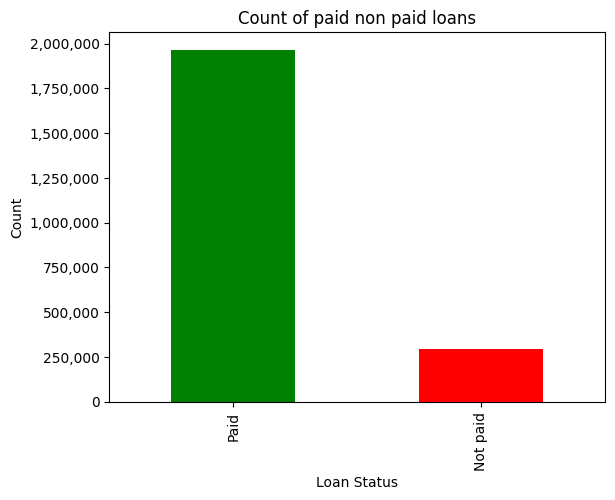

In [25]:
data = feature_engineer.data.loan_status.value_counts()

# Create a color list based on the order of the bars
colors = ['green' if label==1 else 'red' for label in data.index]

ax = data.plot(kind='bar', color=colors, title='Count of paid non paid loans', xlabel='Loan Status', ylabel='Count')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))  # Use ',' as thousand separator

# Change the X-ticks labels
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Paid' if label == '1' else 'Not paid' for label in labels]
ax.set_xticklabels(labels)

plt.show()


There is a clear unbalance in the objective class

## 3.4 One hot encoding

In [16]:
feature_engineer._one_hot_encode()

Columns encoded: Index(['addr_state', 'application_type', 'home_ownership',
       'initial_list_status', 'purpose', 'sub_grade', 'term',
       'verification_status', 'disbursement_method'],
      dtype='object')


## 3.5 Standardize numerical variables

In order to represent the numerical variables in a similar scale, we are going to standardize them.

In [17]:
feature_engineer._standardize_dataframe()

## 3.6 Save data

In [18]:
feature_engineer.save_data(feature_engineer.destination_directory, 'fe_data.csv')

Data saved to ./data


# 4 How are we going to split the data?
For this exercise we need to split the data by period as we are going to train different models for each period. The main problem we have is that issue_d is the date issued, but if we were in the real world we wouldn't know the true label of a loan until it's paid or charged off.

We have 2 columns that can gives an idea about when a loan is finished, 'term' and 'last_pymnt_d'. The first one is the length of the loan in months and the later is the date of the last payment. The problem with the second one is that it's seems to be a little bit confusing as it almost never coincides with the termination date of the loan (maybe it's really common to pay the loan before the last payment date) and also when we issue a loan we would never know when the last payment would be, but we would know when is supposed to finish. Therefore, 'finished_d' is going to be our column to decide how to split the data.

Text(0.5, 1.0, 'Number of loans over time')

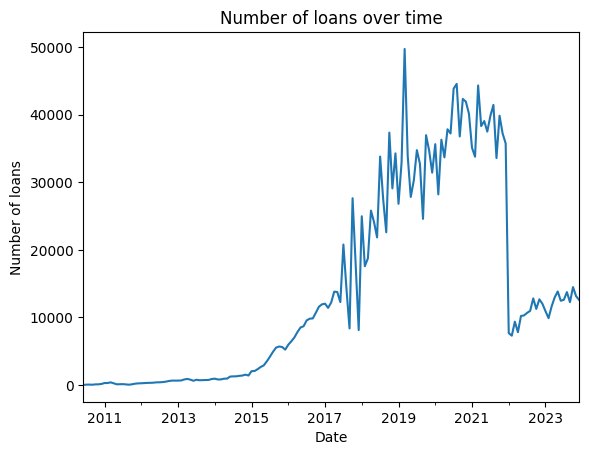

In [19]:
dates_data = pd.read_csv(
    DATES_DATA_PATH 
, parse_dates=['issue_d', 'last_pymnt_d', 'finished_d'] 
, index_col=0)
dates_data

dates_data['finished_d'].value_counts().sort_index().plot()
x_label = 'Date'
y_label = 'Number of loans'
title = 'Number of loans over time'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

We can see how until 2011 we don't start to have a significant number of loans that have been paid or charged off, we are going to break teh dataset in periods of 6 months according to this variable. It is expected that at the beggining we have very little data and the model might be bad as we might not be capturing the full varianze of the population, but as we get more data the model should improve.

Text(0.5, 1.0, 'Number of loans over time accumulated')

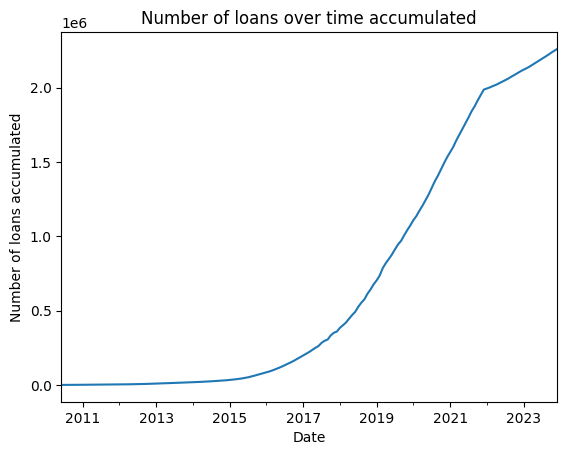

In [20]:
dates_data['finished_d'].value_counts().sort_index().cumsum().plot()
x_label = 'Date'
y_label = 'Number of loans accumulated'
title = 'Number of loans over time accumulated'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)